In [1]:
# include packages
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

import numpy as np
import PIL.Image
from IPython.display import display, Audio
import time as time

from scipy import signal


In [2]:
MODEL_BASE_PATH = "/capstone/project/models"
KICK_PATH = MODEL_BASE_PATH + "/kickdrum3"
HIHAT_PATH = MODEL_BASE_PATH + "/hihat_open"
SNARE_PATH = MODEL_BASE_PATH + "/snare"

KICK_MODEL = KICK_PATH + "/model.ckpt-609"
HIHAT_MODEL = HIHAT_PATH + "/model.ckpt-2585"
SNARE_MODEL = SNARE_PATH + ""

DESTINATION_PATH = "/capstone/project/generated"
KICK_DEST = DESTINATION_PATH + "/kick"
HIHAT_DEST = DESTINATION_PATH + "/hihat"
SNARE_DEST = DESTINATION_PATH + "/snare"

In [3]:
# apply a butterfield (low pass filter)
# to clean up the sound wave/signal
def apply_butterfield(sig, order, nyquest_rate):
    b, a = signal.butter(order, nyquest_rate)
    output = signal.filtfilt(b, a, sig, padlen=150)
    
    return output

In [4]:
# moving average filter
# smooth out waveform
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return (ret[n - 1:] / n)  # multiply to address dampening of amplitude

In [5]:
# generate num amount of soundTypes (kick, hihat, snare)
def generateSounds(soundType, ngenerate):
    
    # select the correct model based on type
    modelPath = ""
    meta = ""
    dest = ""
    if soundType == 'kick':
        modelPath = KICK_MODEL
        meta = KICK_PATH + '/infer/infer.meta'
        dest = KICK_DEST
    elif soundType == 'hihat':
        modelPath = HIHAT_MODEL
        meta = HIHAT_PATH + '/infer/infer.meta'
        dest = HIHAT_DEST
    elif soundType == 'snare':
        modelPath = SNARE_MODEL
        meta = SNARE_PATH + '/infer/infer.meta'
        dest = SNARE_DEST
    else:
        return ("error", [])
    
    # Load the model
    tf.reset_default_graph()
    saver = tf.train.import_meta_graph(meta)
    graph = tf.get_default_graph()
    sess = tf.InteractiveSession()
    saver.restore(sess, modelPath)
    
    #start time
    start = time.time()

    # Sample latent vectors - from collab nb
    _z = (np.random.rand(ngenerate, 100) * 2.) - 1.

    # Generate
    z = graph.get_tensor_by_name('z:0')
    G_z = graph.get_tensor_by_name('G_z:0')[:, :, 0]

    start = time.time()
    _G_z = sess.run(G_z, {z: _z})
    print('Finished! (Took {} seconds)'.format(time.time() - start))

    #plot one wav
    #look at wav file
    plt.figure(figsize=(20,20))
    plt.plot(_G_z[0])
    plt.xlabel('time')
    plt.ylabel('amplitude')

    # export each generated sound to wav file
    for i in range(len(_G_z)):
        outname = dest + "/gen_" + soundType + "_" + str(i) + ".wav"
        
        # test
        # apply butterfield filter to each sound
        _G_z[i] = apply_butterfield(_G_z[i], 1, .125)
        wavfile.write(outname,rate=16000,data=_G_z[i])

    for i in range(5):
        print('-' * 80)
        print('Example {}'.format(i))
        #display(PIL.Image.fromarray(_G_z_spec[i])) - this is just for image
        display(Audio(_G_z[i], rate=16000))

INFO:tensorflow:Restoring parameters from /capstone/project/models/kickdrum3/model.ckpt-609
Finished! (Took 1.1259398460388184 seconds)
--------------------------------------------------------------------------------
Example 0


--------------------------------------------------------------------------------
Example 1


--------------------------------------------------------------------------------
Example 2


--------------------------------------------------------------------------------
Example 3


--------------------------------------------------------------------------------
Example 4


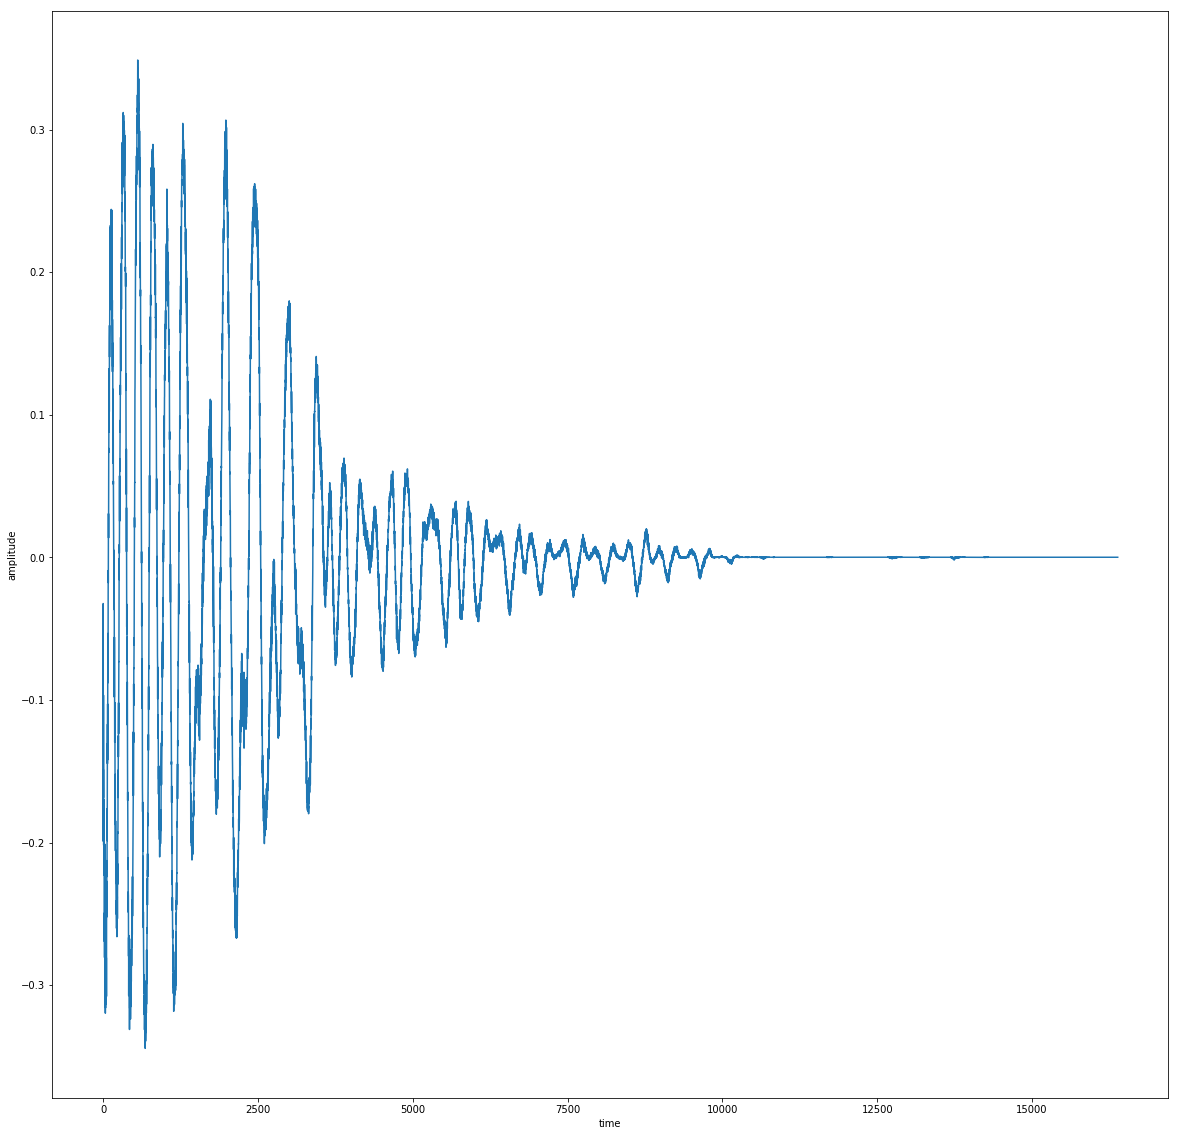

In [6]:
generateSounds("kick", 5)

INFO:tensorflow:Restoring parameters from /capstone/project/models/hihat_open/model.ckpt-2585
Finished! (Took 0.04782724380493164 seconds)
--------------------------------------------------------------------------------
Example 0


/home/ec2-user/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


--------------------------------------------------------------------------------
Example 1


--------------------------------------------------------------------------------
Example 2


--------------------------------------------------------------------------------
Example 3


--------------------------------------------------------------------------------
Example 4


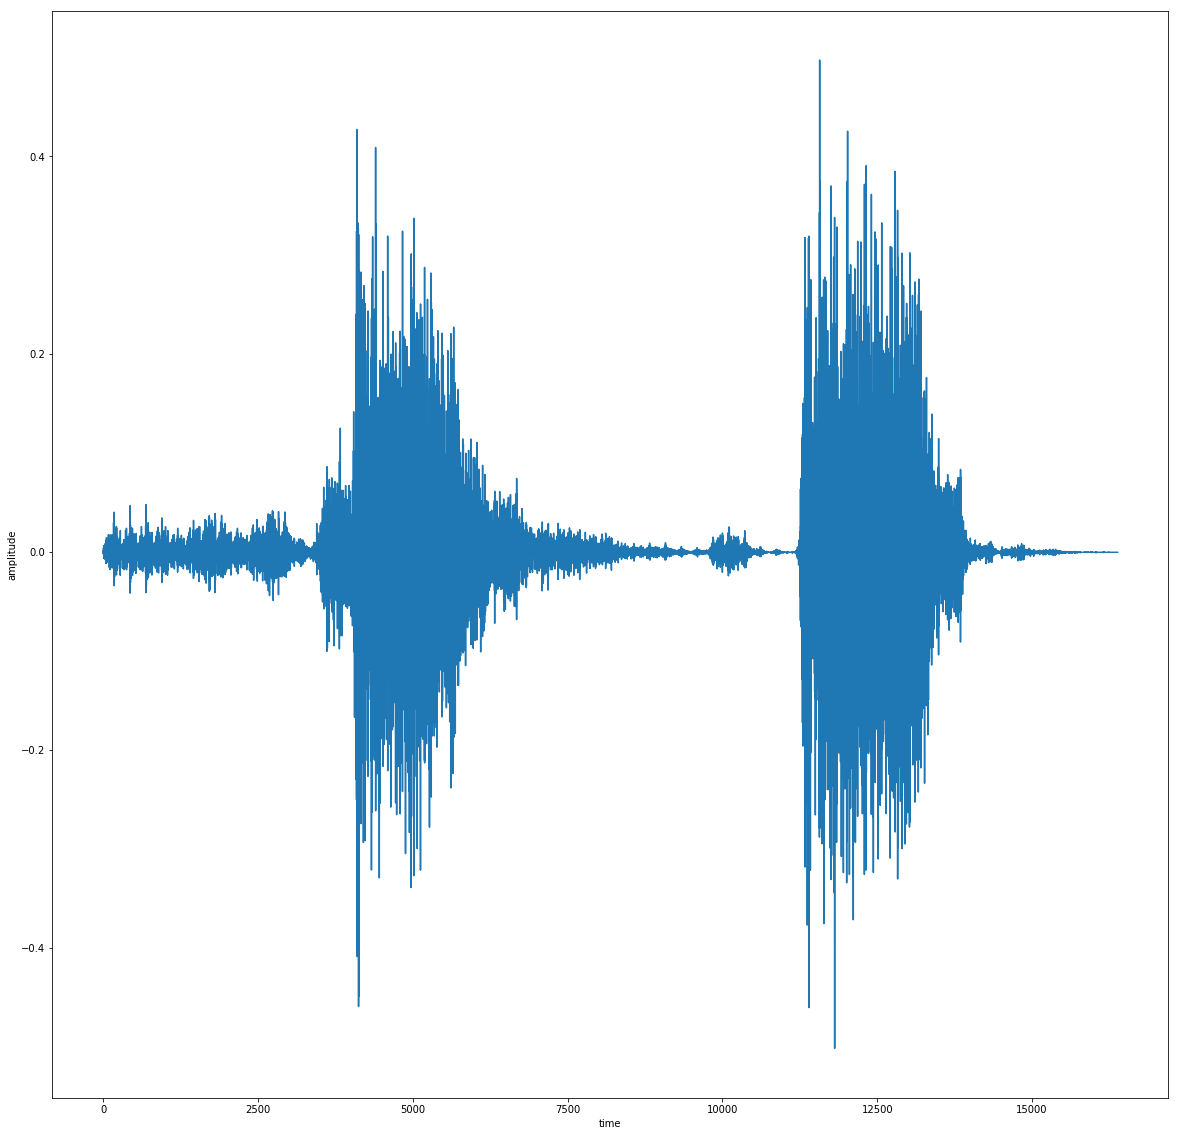

In [7]:
generateSounds("hihat", 5)